#### Get MCP tools from server and test them

In [1]:
import utils

# Set API key to env variable
utils.init_openai()
utils.init_langsmith()

# Bartek localhost MCP Server URL
mcp_server_url = "http://127.0.0.1:8000/mcp"

In [2]:
from fastmcp import Client

# Create instance of the MCP client and manually start the session
# This allows to create tools and use them in different contexts without context managers
# Requires manual cleanup of the session
client = Client(mcp_server_url)
await client.__aenter__()

In [3]:
from langchain_mcp_adapters.tools import load_mcp_tools

tools = await load_mcp_tools(client.session)
tools


[StructuredTool(name='add_numbers', description='Adds two integers and returns the result.\n\nArguments:\n  a: First integer.\n  b: Second integer.\n\nReturns:\n  A dict with the sum of a and b.', args_schema={'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x0000012541264400>),
 StructuredTool(name='read_first_line', description="Accepts a base64‑encoded file content as a string.\nSaves it in the root folder, reads only the first line,\nand returns it alongside full length and file location.\n\nArguments:\n  file_as_b64: Base64‑encoded content of a text file.\n\nReturns:\n  A dict with keys 'first_line', 'length', and 'path'.", args_schema={'properties': {'file_as_b64': {'title': 'File As B64', 'type': 'string'}}, 'required': ['file_as_b64'], 'type': 'object'}, response_format='co

In [4]:
# Test simple add_numbers tool
await tools[0].ainvoke({"a": 2, "b": 3})

'{"sum":5}'

In [5]:
import base64

def encode_file_to_base64(file_path: str) -> str:
    """
    Reads a file from the given path and encodes its contents to a base64 string.

    Args:
        file_path (str): Path to the file.

    Returns:
        str: Base64-encoded string of the file contents.
    """
    with open(file_path, "rb") as file:
        file_content = file.read()
    encoded = base64.b64encode(file_content).decode('utf-8')
    return encoded

In [6]:
# Test tool that accepts file as base64 encoded string
encoded_example_file = encode_file_to_base64("./example.txt")
result = await tools[1].ainvoke({"file_as_b64": encoded_example_file})

print(encoded_example_file)
print(result)

VGhpcyBpcyBleGFtcGxlIGJvaS4NCg0KVGhlcmUgaXMgYSBsb3Qgb2Yga25vd2xlZGdlIGhlcmUuIA0KSW1wb3NzaWJsZSB0byBjb21wcmVoZW5kIGFsbCBvZiBpdC4NCg==
{"first_line":"This is example boi.","length":"4","path":"tmp.txt"}


#### Define Graph of Agent

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)
llm_with_tools


RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000012544B63690>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000012544FABED0>, root_client=<openai.OpenAI object at 0x0000012544B63650>, root_async_client=<openai.AsyncOpenAI object at 0x0000012544FAB9D0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add_numbers', 'description': 'Adds two integers and returns the result.\n\nArguments:\n  a: First integer.\n  b: Second integer.\n\nReturns:\n  A dict with the sum of a and b.', 'parameters': {'properties': {'a': {'type': 'integer'}, 'b': {'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'read_first_line', 'description': "Accepts a base64‑encoded file content as a string.\nSaves it in the root folder, reads only the first line,

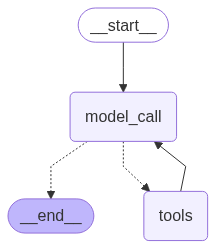

In [8]:
from typing import Optional
from langchain_core.messages import SystemMessage, AIMessage
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display


class State(MessagesState):
    file_path: Optional[str]

default_tool_node = ToolNode(tools)

# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant that has access to some cool tools." \
            "If the argument in the tool you are using is file in base64 (b64) instead ALWAYS pass path to this file." )

def model_call(state: State):
   # This node simulates model calls - to not instantiate memory and sessions I run it stateless
   file_message = SystemMessage(content=f"User has added a file to the this conversation with the path: {state['file_path']}.")
   return {"messages": [llm_with_tools.invoke([sys_msg] + [file_message] + state["messages"])]}

async def tools_call(state: State):
    # This node simulates child class of the ToolNode. 
    # It should implement custom file handling while allowing for standard functionality of the ToolNode
    # Check tool calling parameters and if they contain file_as_b46 keyword - get file and convert to base64
    
    if isinstance(state["messages"][-1], AIMessage):
        tool_call_args = state["messages"][-1].tool_calls[0]['args']
        if "file_as_b64" in tool_call_args:
            state["messages"][-1].tool_calls[0]['args']["file_as_b64"] = encode_file_to_base64(tool_call_args["file_as_b64"])
        else:
            pass
    
    result = await default_tool_node.ainvoke(state)

    return result
   

# Graph
builder = StateGraph(State)

# Define nodes: these do the work
builder.add_node("model_call", model_call)
builder.add_node("tools", tools_call)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "model_call")
builder.add_conditional_edges(
    "model_call",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "model_call")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

#### Test The Agent

In [9]:
from langchain_core.messages import HumanMessage

# This is example of user sending a message and a file
# File will be added in UI, uploaded to conversation and its path/id added as follows to agent state 
messages = await react_graph.ainvoke({"messages": HumanMessage(content="Hello! What is first line of a file I uploaded?"), "file_path": "./example.txt"}) # type: ignore
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello! What is first line of a file I uploaded?
================================== Ai Message ==================================
Tool Calls:
  read_first_line (call_mCksveFOPWkPyCECC6Zt1oQC)
 Call ID: call_mCksveFOPWkPyCECC6Zt1oQC
  Args:
    file_as_b64: VGhpcyBpcyBleGFtcGxlIGJvaS4NCg0KVGhlcmUgaXMgYSBsb3Qgb2Yga25vd2xlZGdlIGhlcmUuIA0KSW1wb3NzaWJsZSB0byBjb21wcmVoZW5kIGFsbCBvZiBpdC4NCg==
================================= Tool Message =================================
Name: read_first_line

{"first_line":"This is example boi.","length":"4","path":"tmp.txt"}
================================== Ai Message ==================================

The first line of the file you uploaded is: **"This is example boi."**


In [115]:
# Cleanup of the client session
await client.__aexit__(None, None, None)